# Reidentify known parameters for a simple SIR model

The Starsim framework includes a built-in susceptible-infected-recovered (SIR) within-host progression module that can be used as a building block to developing more realistic agent-based models. Here, we use that SIR within-host module in combination with mixing pool transmission to create a simple SIR disease model. 

Here, we use that SIR disease model to test two calibration workflows. The goal is to assess if they able to re-identify a known "true" set of parameters and explore the resulting latent trajectories. The two workflows demonstrated are:
1. [Likelihood maximization using the optuna package as integrated with Starsim](#optimization)
2. [Posterior sampling using a Bayesian workflow](#sampling)

 Re-identifying the known parameter values from synthetic data provides reassurance that the calibration workflow is functioning as expected. For a more realistic Starsim calibration example, please see [Calibration](workflows_calibration.ipynb).

[TODO]: <> (Add link to ModelingHub deterministic example once the URL is live.)

In [1]:
# Configure notebook autoreloading and inline plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

##%% Imports and settings
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
import starsim as ss
import numpy as np
import pandas as pd
import sciris as sc
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

### Stochastic SIR using Optuna outside of Starsim
<a id="ex1"></a>

First, we create a simple agent-based SIR simulation using Starsim.

In [2]:
def make_sim():
    """
    Make a simple SIR simulation using Starsim.

    Returns
    -------
    Sim
        A single simulation that has been configured, but not initialized or run.
    """
    sir_pars = dict(
        init_prev = 0.01,
        p_death = 0,
    )
    sir = ss.SIR(pars=sir_pars)

    net = ss.MixingPool(
        beta = 1, # This is a multiplier on the disease beta
        n_contacts = 1,
    )

    sim_pars = dict(
        n_agents = 1000,
        dt = ss.days(1),
        start = '2025-01-01',
        dur = 100,
        verbose = 0,
    )
    sim = ss.Sim(pars=sim_pars, diseases=sir, networks=net)
    return sim

def modify_sim(sim, calib_pars, rand_seed=0):
    """
    Modify the given simulation with the calibration parameters and random seed.
    
    Parameters
    ----------
    sim : Sim
        The simulation to modify.
    calib_pars : dict
        The calibration parameters to apply; note that the parameter values to use are stored in "value."
    rand_seed : int
        The random seed to use for the simulation.

    Returns
    -------
    Sim
        The modified simulation.
    """

    # Explicitly look for each of the calibration parameters and set the appropriate values
    if 'beta' in calib_pars:
        β = ss.perday(calib_pars['beta']['value'])
        sim.pars.diseases.pars['beta'] = β

    if 'gamma' in calib_pars:
        γ = calib_pars['gamma']['value']
        sim.pars.diseases.pars['dur_inf'].set(1/γ)

    sim.pars['rand_seed'] = rand_seed

    return sim


def run_starsim(pars, rand_seed=0):
    """
    Run a Starsim SIR model with given parameters and random seed, returning results.
    
    Parameters
    ----------
    pars : dict
        The parameters dictionary with Optuna a values stored in "value."
    rand_seed : int
        The random seed to use for the simulation.

    Returns
    -------
    dataframe
        The results of the SIR model with columns of S, I, and R and index of Time.
    """
    # Make and modify the simulation
    sim = make_sim()
    sim = modify_sim(sim, pars, rand_seed)

    sim.run() # Run the simulation

    # Extract the results
    results = pd.DataFrame(dict(
        S = sim.results.sir.n_susceptible,
        I = sim.results.sir.n_infected,
        R = sim.results.sir.n_recovered,
    ), index=pd.Index(sim.results.timevec, name='Time'))
    results['rand_seed'] = rand_seed # Store the random seed for later reference

    return results

That set the basic machinery of the SIR simulation model. Next, we'll create some synthetic data to use as calibration targets. Because the model is stochastic, we'll average over several replicates.

Here is the data extracted from the average simulation to be used during calibration:



,x,n,Prevalence
t,,,
2025-01-21,75,1000.0,0.07504
2025-02-10,373,1000.0,0.37324
2025-03-22,413,1000.0,0.41360


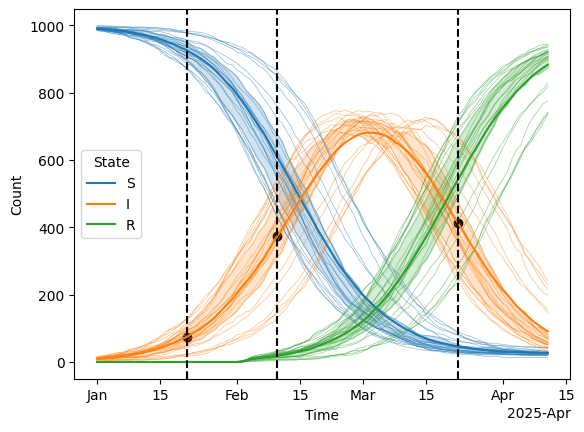

In [3]:
n_reps = 25 # Number of repetitions to run

# These are the true parameters the optimizer will later try to identify
true_pars = dict(
    beta = dict(value=0.12),
    gamma = dict(value=0.03),
)

# Run the starsim SIR simulations in parallel. If you need to run in serial, for example when debugging, simply set serial=True
results_list = sc.parallelize(run_starsim, pars=true_pars, iterkwargs=dict(rand_seed=np.arange(n_reps)), serial=False)
results = pd.concat(results_list) # Combine the results into a single DataFrame
ave = results.groupby('Time').mean().drop(columns='rand_seed') # Average the results over the repetitions

# Extract synthetic data for calibration
observation_times = np.array([pd.Timestamp('2025-01-01')+pd.DateOffset(days=d) for d in [20, 40, 80]])
starsim_data = pd.DataFrame({
    'x': ave.loc[observation_times, 'I'].astype(int),
    'n': ave.loc[observation_times].sum(axis=1),
    'Prevalence': ave.loc[observation_times, 'I'] / ave.loc[observation_times].sum(axis=1)
}, index=pd.Index(observation_times, name='t'))

print('Here is the data extracted from the average simulation to be used during calibration:\n')
display(starsim_data)

# Plot the results, vertical dashed lines indicate the observation times where prevalence is measured
df = results.reset_index().melt(id_vars=['Time', 'rand_seed'], value_vars=['S', 'I', 'R'], var_name='State', value_name='Count')
ax = sns.lineplot(data=df, hue='State', x='Time', y='Count', units='rand_seed', estimator=None, alpha=0.5, lw=0.5, legend=False)
sns.lineplot(data=df, hue='State', x='Time', y='Count', errorbar=('pi', 50), ax=ax, legend=True)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data');

Now we'll set about trying to calibrate to this data using the [Optuna](optuna.org) hyperparameter optimization library.

In [4]:
# We will calibrate two parameters, beta and gamma, each allowed to take on values between 0 and 1.
calib_pars = dict(
    beta = {'low': 0, 'high': 0.25},
    gamma = {'low': 0, 'high': 0.10},
)

def evaluate(results, calib_data):
    """
    Evaluate the results of a simulation against calibration data.

    Parameters
    ----------
    results: DataFrame
        The results of a simulation.
    calib_data: DataFrame
        The calibration data to compare against.

    Returns
    -------
    float
        The squared error between the simulation results and the calibration data.
    """
    squared_error = 0
    for step, expected in calib_data.iterrows():
        observed = results.loc[step, 'I'] / results.loc[step].sum()
        squared_error += (observed - expected.values[0])**2
    return squared_error

def trial_to_pars(trial):
    """
    Map an Optuna trial to a parameter spec.

    Parameters
    ----------
    trial: optuna.Trial
        The trial to map.

    Returns
    -------
    dict
        The parameters dictionary with Optuna a values stored in "value."
    """
    pars = sc.dcp(calib_pars)
    for name, spec in pars.items():
        spec['value'] = trial.suggest_float(name=name, **spec)
    return pars

Objective value threshold reached: 0.0037757792000000043. Stopping study.
The best parameters identified by the optimization are:
    * {'beta': 0.1327120409820735, 'gamma': 0.03133230318382905}
    These parameters should be close to the true parameters:
    * {'beta': {'value': 0.12}, 'gamma': {'value': 0.03}}
    The best parameters resulted in a loss of 0.0037757792000000043.


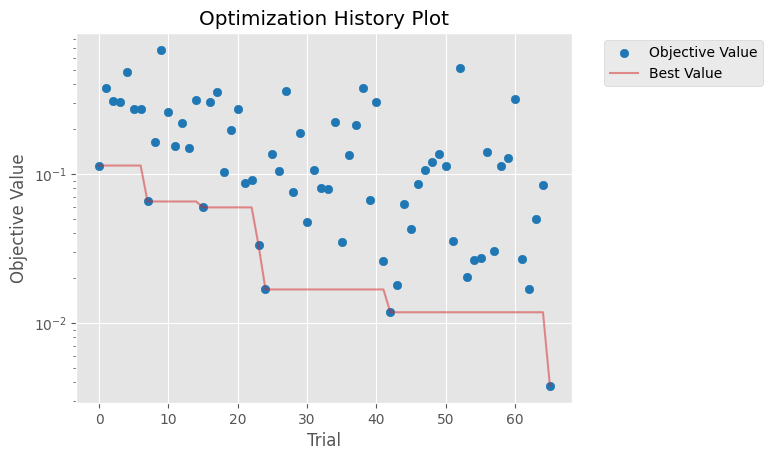

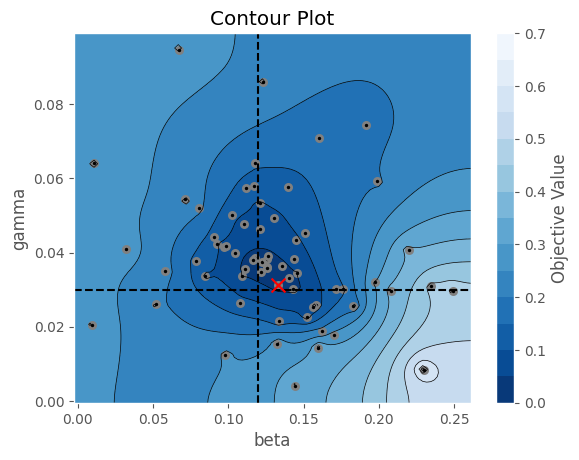

In [5]:
def objective(trial):
    """
    Evaluate a trial by running the Starsim model and comparing the results to the calibration data.

    Parameters
    ----------
    trial: optuna.Trial
        The trial to map.

    Returns
    -------
    float
        The objective value of the trial
    """
    pars = trial_to_pars(trial)
    result = run_starsim(pars, rand_seed=0)
    objective = evaluate(result[['S', 'I', 'R']], starsim_data[['Prevalence']])
    return objective

def callback_on_threshold(study, trial):
    # Assuming we want to minimize the objective
    if study.best_value is not None and study.best_value < 1e-2:
        print(f"Objective value threshold reached: {study.best_value}. Stopping study.")
        study.stop()


# The following two lines create an Optuna study and optimize the objective function - easy!
study = optuna.create_study()
study.optimize(objective, n_trials=2500, callbacks=[callback_on_threshold]) # We'll run up to 2,500 total trials. This may take a few minutes, depending on your computer. Consider reducing this number if you like.

# Print a summary
sc.colorize(color='blue', string=f'The best parameters identified by the optimization are:\n\
    * {study.best_params}\n\
    These parameters should be close to the true parameters:\n\
    * {true_pars}\n\
    The best parameters resulted in a loss of {study.best_value}.')

# Plot the results
fig = optuna.visualization.matplotlib.plot_optimization_history(study);
fig.axes.set_yscale('log')

ax = optuna.visualization.matplotlib.plot_contour(study);
ax.axvline(true_pars['beta']['value'], ls='--', color='black')
ax.axhline(true_pars['gamma']['value'], ls='--', color='black')
ax.scatter(study.best_params['beta'], study.best_params['gamma'], 100, marker='x', color='red', zorder=10);

The parameters seem pretty good! Let's see what simulation look like using the best parameters.

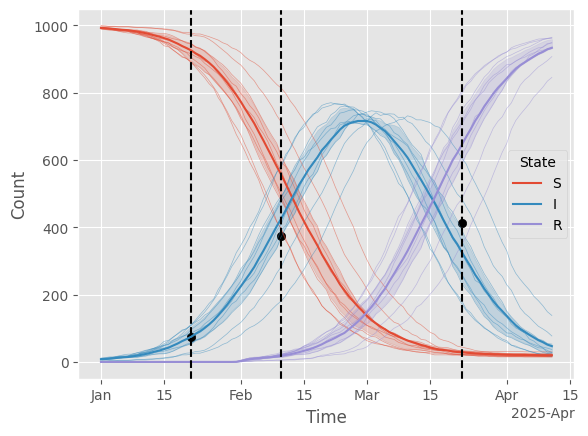

In [6]:
n_reps = 10 # Number of repetitions to run

# These are the true parameters the optimizer will later try to identify.
best_pars = dict(
    beta = dict(value=study.best_params['beta']),
    gamma = dict(value=study.best_params['gamma']),
)

# Run the starsim SIR simulations in parallel. If you need to run in serial, for example when debugging, simply set serial=True
results_list = sc.parallelize(run_starsim, pars=best_pars, iterkwargs=dict(rand_seed=np.arange(n_reps)), serial=False)
results = pd.concat(results_list) # Combine the results into a single DataFrame

# Plot the results, vertical dashed lines indicate the observation times where prevalence is measured
df = results.reset_index().melt(id_vars=['Time', 'rand_seed'], value_vars=['S', 'I', 'R'], var_name='State', value_name='Count')
ax = sns.lineplot(data=df, hue='State', x='Time', y='Count', units='rand_seed', estimator=None, alpha=0.5, lw=0.5, legend=False)
sns.lineplot(data=df, hue='State', x='Time', y='Count', errorbar=('pi', 50), ax=ax, legend=True)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data')

The fit looks great! Onto the next example.

### Stochastic SIR using Optuna integrated within Starsim
<a id="ex2"></a>

The previous example used the Optuna Bayesian optimization algorithm as a "wrapper" around a stochastic disease model. Starsim provides built-in integration with Optuna to make advanced model calibration easier. We demonstrate that linkage below.

In this example, we use a Beta-binomial likelihood function; however, results shouldn't be too different from the simple example above that used a squared error metric.

In [7]:
sim = make_sim() # Begin by making a single "base" simulation with default parameters

# This example will use a single calibration component
# We choose a Beta-binomial functional form to represent the "prevalence survey" data, taking advantage of both the numerator (x) and denominator (n) data.
prevalence_component = ss.BetaBinomial(
    name = 'SIR Disease Prevalence',
    conform = 'step_containing', # The starsim_data data has a date for each observation. The "step_containing" conform method will extract simulation results on the time step containing the observation date.

    # Here is the data we are trying to match, using the "x" and "n" columns from the starsim_data DataFrame.
    expected = starsim_data[['x', 'n']],

    # And here is how we will extract the relevant data from the simulation results
    extract_fn = lambda sim: pd.DataFrame({
        'x': sim.results.sir.n_infected, # Numerator
        'n': sim.results.n_alive, # Denominator
    }, index=pd.Index(sim.results.timevec, name='t')),
)

# Make the calibration
calib = ss.Calibration(
    sim = sim,                              # The base simulation
    calib_pars = calib_pars,                # The calibration parameters
    build_fn = modify_sim,                  # The function to modify the base simulation with the calibration parameters
    reseed = False,                         # In this example, we will not reseed the simulation for each calibration trial
    components = [prevalence_component],    # The calibration components
    total_trials = 500,                     # We will run 500 total trials, as before. This might take some time, depending on your computer.
    verbose = False,                        # Shh...

    sampler = optuna.samplers.TPESampler(n_startup_trials=100)
)

calib.calibrate() # Let's go!

# Print out a summary
sc.colorize(color='blue', string=f'The best parameters identified by the optimization are:\n\
    * {calib.best_pars}\n\
    These parameters should be close to the true parameters:\n\
    * {true_pars}\n\
    The best parameters resulted in a loss of {calib.study.best_value}.')

The best parameters identified by the optimization are:
    * {'beta': 0.13174095318667312, 'gamma': 0.03033018794136041}
    These parameters should be close to the true parameters:
    * {'beta': {'value': 0.12}, 'gamma': {'value': 0.03}}
    The best parameters resulted in a loss of 4.4769037826590266.


It seems like the best parameter values are pretty close to the right values, so that's good. We can look at all the results and easily create a DataFrame containing the top K runs.

In [8]:
df = calib.to_df(top_k=10)
display(df)

,value,datetime_start,datetime_complete,duration,params_beta,params_gamma,state
number,,,,,,,
259,4.476904,2025-10-02 15:43:40.977978,2025-10-02 15:43:41.104938,0 days 00:00:00.126960,0.131741,0.030330,COMPLETE
249,4.486880,2025-10-02 15:43:40.799039,2025-10-02 15:43:41.022800,0 days 00:00:00.223761,0.131698,0.030450,COMPLETE
447,4.528992,2025-10-02 15:43:44.069848,2025-10-02 15:43:44.192101,0 days 00:00:00.122253,0.132898,0.029365,COMPLETE
248,4.533781,2025-10-02 15:43:40.776043,2025-10-02 15:43:40.934220,0 days 00:00:00.158177,0.131550,0.030530,COMPLETE
251,4.533781,2025-10-02 15:43:40.807303,2025-10-02 15:43:40.930253,0 days 00:00:00.122950,0.131150,0.030560,COMPLETE
258,4.533781,2025-10-02 15:43:40.948720,2025-10-02 15:43:41.078346,0 days 00:00:00.129626,0.131124,0.030552,COMPLETE
254,4.547260,2025-10-02 15:43:40.865345,2025-10-02 15:43:40.995452,0 days 00:00:00.130107,0.132636,0.030535,COMPLETE
262,4.555346,2025-10-02 15:43:40.949142,2025-10-02 15:43:41.176663,0 days 00:00:00.227521,0.130963,0.030623,COMPLETE
245,4.570233,2025-10-02 15:43:40.709781,2025-10-02 15:43:40.844662,0 days 00:00:00.134881,0.131014,0.030641,COMPLETE


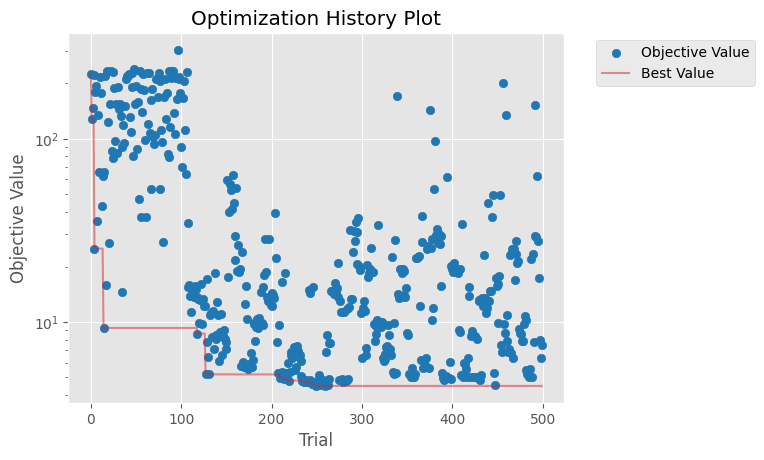

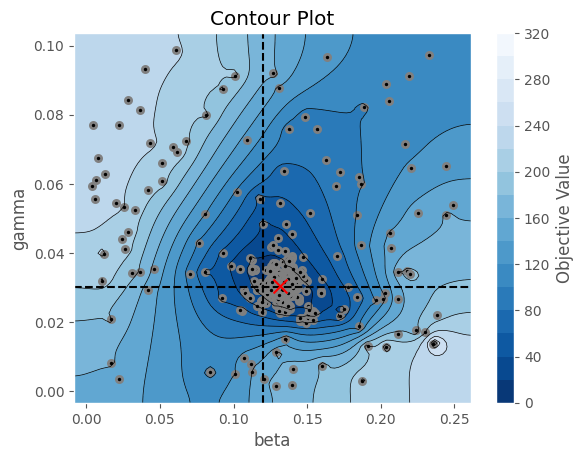

In [9]:
# Plot the results
figs = calib.plot_optuna(['plot_optimization_history', 'plot_contour']);
figs[0].axes.set_yscale('log')

figs[1].axvline(true_pars['beta']['value'], ls='--', color='black');
figs[1].axhline(true_pars['gamma']['value'], ls='--', color='black');
figs[1].scatter(calib.study.best_params['beta'], calib.study.best_params['gamma'], 100, marker='x', color='red', zorder=10);

Finally, let's run some simulations with the best parameters and compare to the calibration data.

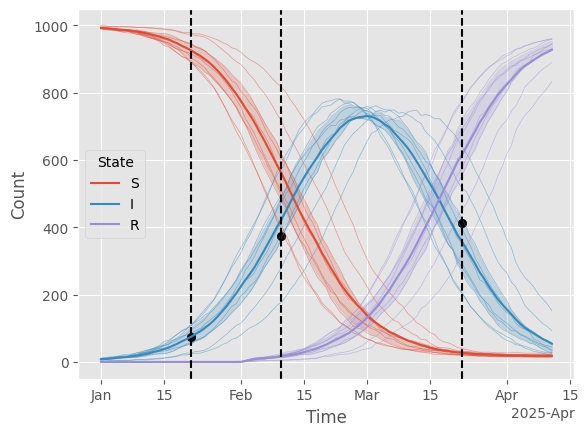

In [10]:
n_reps = 10 # Number of repetitions to run

# These are the true parameters! Shhh, don't tell the optimizer.
best_pars = dict(
    beta = dict(value=calib.study.best_params['beta']),
    gamma = dict(value=calib.study.best_params['gamma']),
)

# Run the starsim SIR simulations in parallel, cool! If you need to run in serial, for example when debugging, simply set serial=True
results_list = sc.parallelize(run_starsim, pars=best_pars, iterkwargs=dict(rand_seed=np.arange(n_reps)), serial=False)
results = pd.concat(results_list) # Combine the results into a single DataFrame

# Plot the results, vertical dashed lines indicate the observation times where prevalence is measured
df = results.reset_index().melt(id_vars=['Time', 'rand_seed'], value_vars=['S', 'I', 'R'], var_name='State', value_name='Count')
ax = sns.lineplot(data=df, hue='State', x='Time', y='Count', units='rand_seed', estimator=None, alpha=0.5, lw=0.5, legend=False)
sns.lineplot(data=df, hue='State', x='Time', y='Count', errorbar=('pi', 50), ax=ax, legend=True)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data');

These results also look great.

# Bayesian calibration using sampling-importance resampling (SIR)

Now let's use a Bayesian calibration approach to see if the results are any different. We'll use a simple ABC rejection sampling with a beta-binomial likelihood. A key difference is that we're learning a posterior distribution over both parameters and trajectories rather than just a point estimate of the parameters.

In [11]:
import numpy as np
from scipy.special import betaln, gammaln

def beta_binomial_likelihood(
    results,
    calib_data,
    kappa=10.0,             # concentration: larger => less over-dispersion
    prior_alpha=1.0,        # used only to smooth
    prior_beta=1.0
):
    """
    Likelihood for Beta-Binomial observation model:
        s_obs ~ BetaBinomial(n_obs, alpha=kappa*p_hat, beta=kappa*(1-p_hat))

    p_hat is computed as (sim_x + prior_alpha) / (sim_n + prior_alpha + prior_beta).
    """

    obs_x = calib_data['x'].values
    obs_n = calib_data['n'].values

    sim_x = results['I']
    sim_n = results.sum(axis=1)

    denom = np.maximum(sim_n + prior_alpha + prior_beta, 1e-12)  # guard
    p_hat = (sim_x + prior_alpha) / denom

    p_hat = np.clip(p_hat, 1e-9, 1 - 1e-9)
    alpha = kappa * p_hat
    beta  = kappa * (1.0 - p_hat)

    # log binomial coefficient: log C(n, x)
    logC = gammaln(obs_n + 1) - gammaln(obs_x + 1) - gammaln(obs_n - obs_x + 1)
    loglik = logC + betaln(obs_x + alpha, obs_n - obs_x + beta) - betaln(alpha, beta)
    return np.exp(np.sum(loglik))


In [12]:
# Define a simple uniform prior over beta and gamma in [0, 1]
def prior_sample(size=1):
    """
    Sample beta and gamma from a uniform prior over [0, 1].

    Parameters
    ----------
    size : int
        Number of samples to draw.

    Returns
    -------
    Pandas DataFrame
        DataFrame of shape (size, 2) with columns [beta, gamma].
    """
    beta = np.random.uniform(calib_pars['beta']['low'], calib_pars['beta']['high'], size)
    gamma = np.random.uniform(calib_pars['gamma']['low'], calib_pars['gamma']['high'], size)

    # Reduced prior range to reduce number of required samples
    #beta = np.random.uniform(0, 0.2, size)
    #gamma = np.random.uniform(0, 0.1, size)
    #return np.column_stack([beta, gamma])
    return pd.DataFrame({'beta': beta, 'gamma': gamma})

In [ ]:
N = 5_000  # Number of prior samples
ABC = 0
BB = 1
use = BB

abc_alpha = 0.01 # For ABC, the fraction of samples to keep

# For Beta-Binomial, the concentration parameter. Lower kappa --> broader
# posterior and higher ESS for the same N. But not a free parameter, kappa comes
# from the over-dispersion in the observed data.
kappa = 10 

# Sample from the prior
prior_samples = prior_sample(size=N)

rand_seeds = np.random.randint(0, 1e6, size=2*N)
rand_seeds = np.unique(rand_seeds)[:N]

# Prepare parameter dicts for each sample
sample_pars_list = [
    {
        'pars': {'beta': {'value': row['beta']}, 'gamma': {'value': row['gamma']}},
        'rand_seed': rand_seeds[idx]  # Random seed for each simulation
    }
    for idx, row in prior_samples.iterrows()
]

# Run simulations in parallel and collect trajectories
sim_results_list = sc.parallelize(run_starsim, iterkwargs=sample_pars_list, serial=False)

# Store latent state trajectories for each sample
trajectories = pd.concat(sim_results_list) \
    .reset_index() \
    .set_index(['rand_seed', 'Time'])


In [14]:
# Compute likelihoods for each sample
likelihoods = []
for rand_seed, sim_result in trajectories.groupby('rand_seed'):
    sim_sir = sim_result.loc[rand_seed].loc[observation_times, ['S', 'I', 'R']]
    likelihood_abc = evaluate(sim_sir, starsim_data[['Prevalence']])
    likelihood_bb = beta_binomial_likelihood(sim_sir, starsim_data, kappa=kappa)

    likelihoods.append((rand_seed, likelihood_abc, likelihood_bb))

results = pd.DataFrame(likelihoods, columns=['rand_seed', 'abc_distance', 'bb_likelihood'])
results = pd.concat([prior_samples, results], axis=1).set_index('rand_seed')

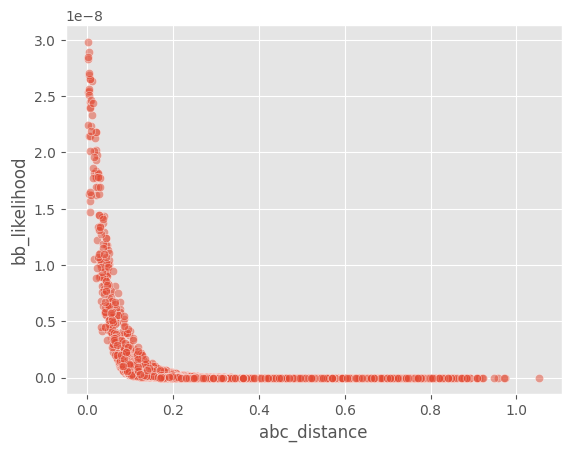

In [15]:
# Scatter likelihoods to compare ABC and BB
sns.scatterplot(data=results, x='abc_distance', y='bb_likelihood', alpha=0.5);

In [ ]:
results['abc_weight'] = 1 - results['abc_distance'] / np.sum(results['abc_distance'])
results['bb_weight'] = results['bb_likelihood'] / np.sum(results['bb_likelihood'])

if use == ABC:
    keep = int(N * abc_alpha)
    resample_seeds = results.sort_values('abc_distance', ascending=True).iloc[:keep].index.values
else:
    # Importance resampling
    ESS = 1 / np.sum(results['bb_weight']**2)
    print(f'Effective Sample Size (ESS) = {ESS:.1f} out of {N}')
    K = np.ceil(1.5 * ESS).astype(int)  # Number of samples to draw
    resample_seeds = np.random.choice(results.index, size=K, replace=True, p=results['bb_weight'])

# Merge results into combined and selected
combined = trajectories.reset_index().merge(results, on='rand_seed').set_index(['rand_seed', 'Time'])
selected = combined.loc[resample_seeds]

# Show posterior samples as a DataFrame
posterior_pars = results.loc[resample_seeds, ['beta', 'gamma']]
display(posterior_pars.head())

Effective Sample Size (ESS) = 245.1 out of 5000


,beta,gamma
rand_seed,,
93678,0.121241,0.027860
457071,0.101169,0.028881
18480,0.113386,0.035567
272042,0.097213,0.062781
443125,0.117083,0.029696


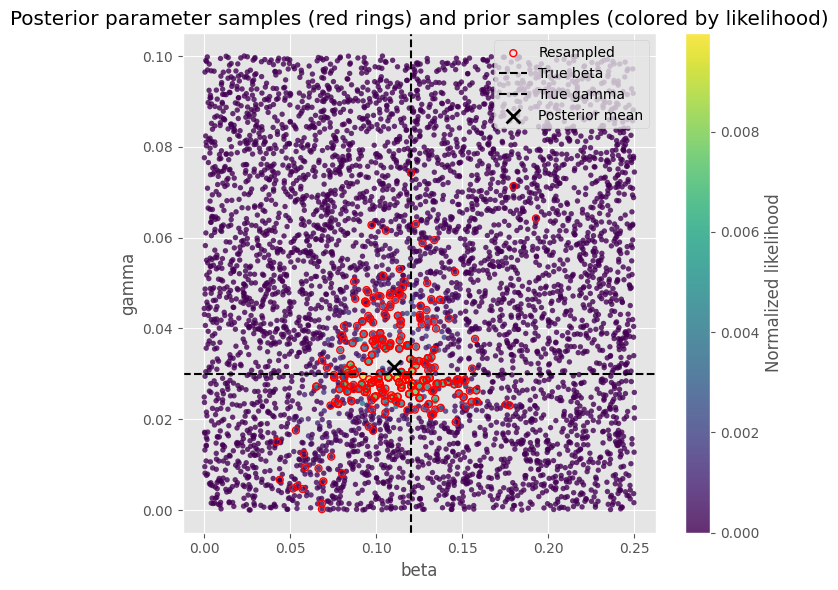

In [34]:
fig, ax = plt.subplots(figsize=(7, 6))
weight_col = 'abc_weight' if use == ABC else 'bb_weight'

# Scatter all prior samples, colored by likelihood
scat = ax.scatter(
    results['beta'], results['gamma'],
    c=results[weight_col], cmap='viridis', s=15, edgecolor='none', alpha=0.8
)

# Overlay red rings for resampled posterior samples
ax.scatter(
    results.loc[resample_seeds, 'beta'], results.loc[resample_seeds, 'gamma'],
    facecolors='none', edgecolors='red', s=25, linewidths=1, label='Resampled'
)

# Overlay the true parameter values and best posterior sample
ax.axvline(true_pars['beta']['value'], ls='--', color='black', label='True beta')
ax.axhline(true_pars['gamma']['value'], ls='--', color='black', label='True gamma')

# Optionally, mark the posterior mean as a black 'x'
posterior_mean = results.loc[resample_seeds, ['beta', 'gamma']].mean(axis=0)
ax.scatter(posterior_mean[0], posterior_mean[1], 100, marker='x', color='black', lw=2, zorder=10, label='Posterior mean')

ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_title('Posterior parameter samples (red rings) and prior samples (colored by likelihood)')
plt.colorbar(scat, ax=ax, label='Normalized likelihood')
plt.legend()
plt.tight_layout()
plt.show()

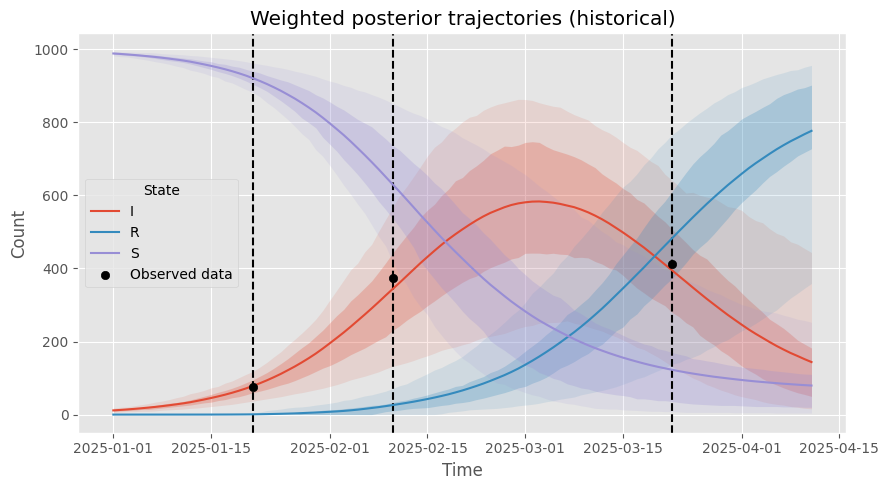

In [28]:
# Use all samples, with weights, to compute mean and quantiles
df = combined \
    .reset_index() \
    .melt(
        id_vars=['Time', 'rand_seed'],
        value_vars=['S', 'I', 'R'],
        var_name='State',
        value_name='Count'
    )
df['Weight'] = df['rand_seed'].map(results['bb_weight']) # Add weights to the DataFrame

def weighted_quantile(values, quantiles, weights):
    v = np.asarray(values, float)
    q = np.atleast_1d(quantiles).astype(float)
    w = np.asarray(weights, float)
    order = np.argsort(v)
    v, w = v[order], w[order]
    cw = np.cumsum(w)
    cw /= cw[-1] if cw[-1] > 0 else 1.0
    return np.interp(q, cw, v)

def summarize(group):
    vals = group['Count'].to_numpy()
    wts  = group['Weight'].to_numpy()
    mean = np.average(vals, weights=wts)
    q05, q25, q75, q95 = weighted_quantile(vals, [0.05, 0.25, 0.75, 0.95], wts)
    return pd.Series({'mean': mean, 'q05': q05, 'q25': q25, 'q75': q75, 'q95': q95})

summary = (
    df.groupby(['Time','State'], sort=True, as_index=False)
      .apply(summarize)
      .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(9,5))
lines = sns.lineplot(data=summary, x='Time', y='mean', hue='State',
                     estimator=None, errorbar=None, ax=ax, zorder=5)

# Get the colors used by seaborn for each state
state_colors = {line.get_label(): line.get_color() for line in ax.lines}

for state, g in summary.groupby('State'):
    color = state_colors.get(state, None)
    ax.fill_between(g['Time'], g['q05'], g['q95'], alpha=0.12, linewidth=0, color=color)  # 90% band
    ax.fill_between(g['Time'], g['q25'], g['q75'], alpha=0.25, linewidth=0, color=color)  # 50% band

for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data', zorder=10);

ax.set_ylabel('Count')
ax.set_title('Weighted posterior trajectories (historical)')
ax.legend(title='State')
plt.tight_layout()

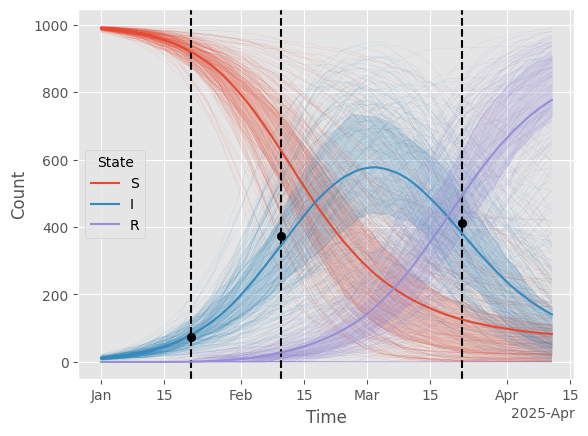

In [27]:
# Plot the results, vertical dashed lines indicate the observation times where prevalence is measured
df = selected \
    .reset_index() \
    .melt(
        id_vars=['Time', 'rand_seed'],
        value_vars=['S', 'I', 'R'],
        var_name='State',
        value_name='Count'
    )

ax = sns.lineplot(data=df, hue='State', x='Time', y='Count', units='rand_seed', estimator=None, alpha=0.5, lw=0.1, legend=False)
sns.lineplot(data=df, hue='State', x='Time', y='Count', errorbar=('pi', 50), ax=ax, legend=True, zorder=5)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data', zorder=10);